In [1]:
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import emcee
import corner
%matplotlib inline


In [2]:
data = np.loadtxt('spectrum_d_0.69_kpc.txt',skiprows=1,dtype=np.float64)
wavelength = data[:,0]
intensity = data[:,1]


Running burn-in...
Running production...


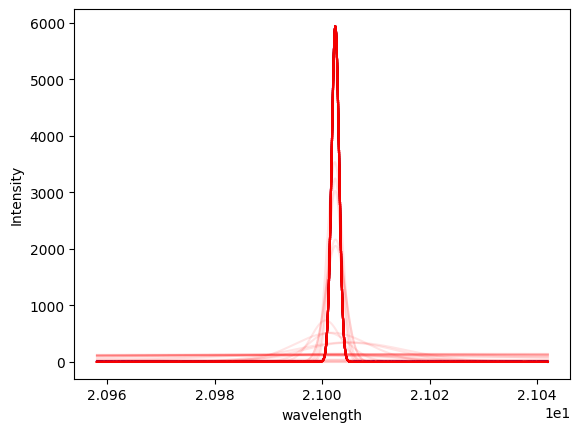

In [3]:
def model(parameters, wavelength=wavelength):
    a, mu, sigma = parameters
    return a* np.exp(-(wavelength - mu)**2 / (2 * sigma**2))

def lnlike(parameters, x, y, yerr):
    return -0.5 * np.sum(((y - model(parameters, x))/yerr) ** 2)

def lnprior(parameters):
    a, mu, sigma = parameters
    if 0<a<10000 and 20.2<mu<21.6 and 0<sigma<1:
        return 0.0
    return -np.inf

def lnprob(parameters, x, y, yerr):
    lp = lnprior(parameters)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(parameters, x, y, yerr)

Yerr = 0.05*intensity
Yerr = np.mean(Yerr)


data = (wavelength, intensity ,Yerr)
nwalkers = 240
niter = 1024
initial = np.array([1, 21, 0.5])
ndim = len(initial)
p0 = [np.array(initial) + 1e-7 * np.random.randn(ndim) for i in range(nwalkers)]


def main(p0,nwalkers,niter,ndim,lnprob,data):
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=data)

    print("Running burn-in...")
    p0, _, _ = sampler.run_mcmc(p0, 100)
    sampler.reset()

    print("Running production...")
    pos, prob, state = sampler.run_mcmc(p0, niter)

    return sampler, pos, prob, state

sampler, pos, prob, state = main(p0,nwalkers,niter,ndim,lnprob,data)

def plotter(sampler,wavelength = wavelength ,intensity = intensity):
    plt.ion()
    plt.plot(wavelength,intensity, color= 'b')
    samples = sampler.flatchain
    for parameters in samples[np.random.randint(len(samples), size=100)]:
        plt.plot(wavelength, model(parameters, wavelength), color="r", alpha=0.1)
    plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
    plt.xlabel('wavelength')
    plt.ylabel('Intensity')
    plt.show()
    
plotter(sampler)

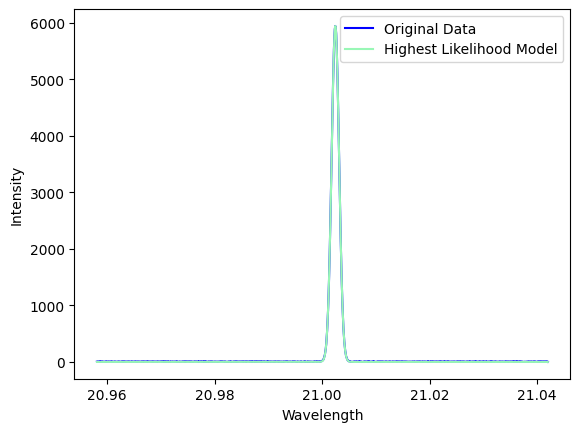

Theta max:  [5.94270615e+03 2.10024518e+01 7.01346844e-04]


In [14]:
new_samples =  sampler.flatchain

new_theta_max  = new_samples[np.argmax(sampler.flatlnprobability)]
new_best_fit_model = model(new_theta_max)
plt.plot(wavelength,intensity,label='Original Data',color='blue')
plt.plot(wavelength,new_best_fit_model,label='Highest Likelihood Model',color='#99f7b6')
plt.legend()
plt.xlabel('Wavelength')
plt.ylabel('Intensity')

plt.show()
print ('Theta max: ',new_theta_max)

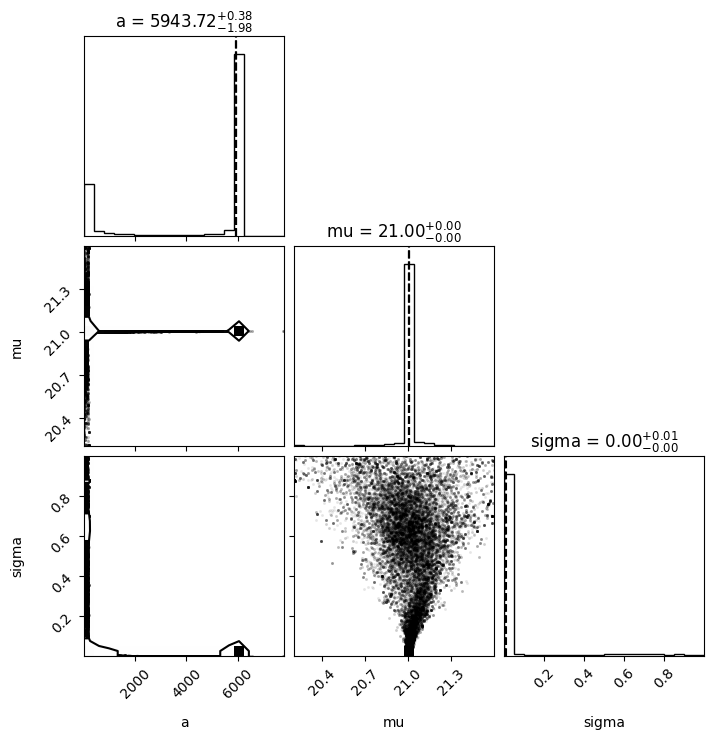

In [5]:
labels = ['a', 'mu', 'sigma']
fig = corner.corner(new_samples,show_titles=True,labels=labels,plot_datapoints=True,quantiles=[0.56, 0.8, 0.84])

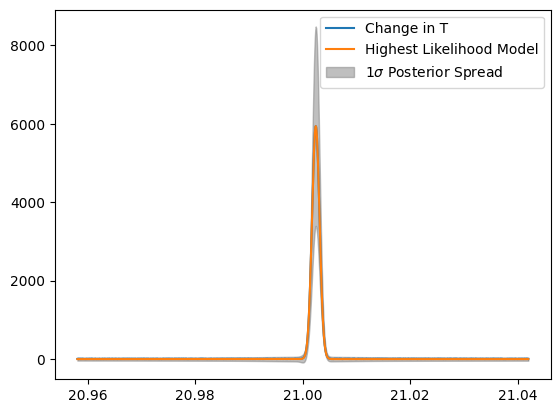

In [6]:
def sample_walkers(nsamples,flattened_chain):
    models = []
    draw = np.floor(np.random.uniform(0,len(flattened_chain),size=nsamples)).astype(int)
    thetas = flattened_chain[draw]
    for i in thetas:
        mod = model(i)
        models.append(mod)
    spread = np.std(models,axis=0)
    med_model = np.median(models,axis=0)
    return med_model,spread
med_model, spread = sample_walkers(100,new_samples)

plt.plot(wavelength,intensity,label='Change in T')
plt.plot(wavelength,new_best_fit_model,label='Highest Likelihood Model')
plt.fill_between(wavelength,med_model-spread,med_model+spread,color='grey',alpha=0.5,label=r'$1\sigma$ Posterior Spread')
plt.legend()